In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read in CSV file
data = pd.read_csv("data.csv") 
data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,6,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,4860406,2011,10,6,16,2,1,04,01,1,...,01,01,2003,01,M,24,11,1,02,1
1,4860407,2011,10,6,16,2,1,04,01,1,...,01,01,2003,02,M,09,31,2,02,2
2,4860408,2011,10,6,16,2,1,04,01,1,...,01,01,2003,03,F,07,22,2,02,2
3,4860409,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,01,M,50,11,1,02,1
4,4860410,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,02,M,15,13,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5860401,2014,UU,U,UU,2,UU,UU,01,U,...,13,07,UUUU,01,M,24,11,1,NN,1
999996,5860402,2014,UU,U,23,2,01,06,05,1,...,1,14,2006,01,M,29,96,2,09,5
999997,5860403,2014,UU,U,14,2,01,02,01,1,...,1,01,2006,01,F,UU,11,2,01,1
999998,5860404,2014,UU,U,22,1,01,06,01,2,...,1,22,UUUU,01,M,67,12,3,01,U


# Data Cleaning

In [3]:
# Data cleaning: P_ISEV
data = data[data['P_ISEV'] != "N"]
data = data[data['P_ISEV'] != "U"]
data = data[data['P_ISEV'] != "X"]
data.P_ISEV = pd.to_numeric(data.P_ISEV)
data[data['P_ISEV'] == 1 ] = 0
data[data['P_ISEV'] == 2 ] = 1
data[data['P_ISEV'] == 3 ] = 1
data.P_ISEV = pd.Categorical(data.P_ISEV)
data['P_ISEV'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [4]:
# Data cleaning: P_SEX
data = data[data['P_SEX'] != "N"]
data = data[data['P_SEX'] != "U"] 
data.P_SEX = pd.Categorical(data.P_SEX)
data['P_SEX'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [5]:
# Data cleaning: C_MNTH
data = data[data['C_MNTH'] != "UU"]
data = data[data['C_MNTH'] != "XX"]
data.C_MNTH = pd.Categorical(pd.to_numeric(data.C_MNTH))
data['C_MNTH'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [6]:
# Data cleaning: C_WDAY
data = data[data['C_WDAY'] != "U"] 
data = data[data['C_WDAY'] != "X"] 
data.C_WDAY = pd.Categorical(pd.to_numeric(data.C_WDAY))
data['C_WDAY'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [7]:
# Data cleaning: C_HOUR
data = data[data['C_HOUR'] != "UU"]
data = data[data['C_HOUR'] != "XX"]
# Make colliosn hour group categories
data['C_HOUR'] = pd.to_numeric(data['C_HOUR'])
data['C_HOUR'] = pd.cut(data['C_HOUR'], bins=[0,3,6,9,12,15,18,21,23,float('inf')], right=False)
data['C_HOUR'].unique()

[[0.0, 3.0)]
Categories (1, interval[float64]): [[0.0, 3.0)]

In [8]:
# Data cleaning: C_VEHS
data = data[data['C_VEHS'] != "UU"]
data = data[data['C_VEHS'] != "XX"]
# Make vehicle collided group categories rather than usuing indidvidual number of cars in collision
data['C_VEHS'] = pd.to_numeric(data['C_VEHS'])
data['C_VEHS'] = pd.cut(data['C_VEHS'], bins=[1,5,26,float('inf')], right=False)
data['C_VEHS'].unique()

[NaN, [1.0, 5.0)]
Categories (1, interval[float64]): [[1.0, 5.0)]

In [9]:
# Data cleaning: C_CONF
data = data[data['C_CONF'] != "QQ"]
data = data[data['C_CONF'] != "UU"]
data = data[data['C_CONF'] != "XX"]
data['C_CONF'] = pd.to_numeric(data['C_CONF'])
data['C_CONF'] = pd.cut(data['C_CONF'], bins=[1,21,31,float('inf')], right=False)
data['C_CONF'].unique()

[NaN, [1.0, 21.0)]
Categories (1, interval[float64]): [[1.0, 21.0)]

In [10]:
# Data cleaning: C_RCFG
data = data[data['C_RCFG'] != "QQ"]
data = data[data['C_RCFG'] != "UU"] 
data = data[data['C_RCFG'] != "XX"]
data.C_RCFG = pd.Categorical(pd.to_numeric(data.C_RCFG))
data['C_RCFG'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [11]:
# Data cleaning: C_WTHR
data = data[data['C_WTHR'] !=  "Q"]
data = data[data['C_WTHR'] !=  "U"]
data = data[data['C_WTHR'] !=  "X"]
data.C_WTHR = pd.Categorical(pd.to_numeric(data.C_WTHR))
data['C_WTHR'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [12]:
# Data cleaning: C_RSUR
data = data[data['C_RSUR'] !=  "Q"]
data = data[data['C_RSUR'] !=  "U"]
data = data[data['C_RSUR'] !=  "X"]
data.C_RSUR = pd.Categorical(pd.to_numeric(data.C_RSUR))
data['C_RSUR'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [13]:
# Data cleaning: C_RALN 
data = data[data['C_RALN'] != "Q"] 
data = data[data['C_RALN'] != "U"] 
data = data[data['C_RALN'] != "X"]
data.C_RALN = pd.Categorical(pd.to_numeric(data.C_RALN))
data['C_RALN'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [14]:
# Data cleaning: C_TRAF 
data = data[data['C_TRAF'] != "QQ"]
data = data[data['C_TRAF'] != "UU"]
data = data[data['C_TRAF'] != "XX"]
data['C_TRAF'] = pd.to_numeric(data['C_TRAF'])
data['C_TRAF'] = pd.cut(data['C_TRAF'], bins=[1,3,8,10,13,15,float('inf')], right=False)
data['C_TRAF'].unique()

[NaN, [1.0, 3.0)]
Categories (1, interval[float64]): [[1.0, 3.0)]

In [15]:
# Data cleaning: V_ID 
data = data[data['V_ID'] != "UU"]
data.V_ID = pd.Categorical(pd.to_numeric(data.V_ID))
data['V_ID'].unique()  

[0, 1]
Categories (2, int64): [0, 1]

In [16]:
# Data cleaning: V_TYPE
data = data[data['V_TYPE'] != "QQ"] 
data = data[data['V_TYPE'] != "UU"] 
data = data[data['V_TYPE'] != "NN"] 
data['V_TYPE'] = pd.to_numeric(data['V_TYPE'])
data['V_TYPE'] = pd.cut(data['V_TYPE'], bins=[0,5,8,9,float('inf')], right=False)
data['V_TYPE'].unique()

[[0.0, 5.0)]
Categories (1, interval[float64]): [[0.0, 5.0)]

In [17]:
# Data cleaning: V_YEAR
data = data[data['V_YEAR'] != "NNNN"] 
data = data[data['V_YEAR'] != "UUUU"] 
data = data[data['V_YEAR'] != "QQQQ"]
# Make vehicle year group categories rather than using indidvidual years
data['V_YEAR'] = pd.to_numeric(data['V_YEAR'])
data['V_YEAR'] = pd.cut(data['V_YEAR'], bins=[1900,1950,1980,1990,2000,2010,float('inf')], right=False)
data['V_YEAR'].unique()

[NaN]
Categories (0, interval[float64]): []

In [18]:
# Data cleaning: P_ID
data = data[data['P_ID'] != "NN"]
data = data[data['P_ID'] != "UU"]
data.P_ID = pd.Categorical(pd.to_numeric(data.P_ID))
data['P_ID'].unique()  

[0, 1]
Categories (2, int64): [0, 1]

In [19]:
# Data cleaning: P_PSN
data = data[data['P_PSN'] != "NN"]
data = data[data['P_PSN'] != "QQ"]
data = data[data['P_PSN'] != "UU"]
data = data[data['P_PSN'] != "XX"]
# Make person position categories
data['P_PSN'] = pd.to_numeric(data['P_PSN'])

# 96 is position unknown so get rid of rows with this
data = data[data['P_PSN'] != 96]
data['P_PSN'] = pd.cut(data['P_PSN'], bins=[11,21,31,34,98,99,float('inf')], right=False)
data['P_PSN'].unique()

[NaN]
Categories (0, interval[float64]): []

In [20]:
# Data cleaning: P_SAFE
data = data[data['P_SAFE'] != "NN"]
data = data[data['P_SAFE'] != "QQ"]
data = data[data['P_SAFE'] != "UU"]
data = data[data['P_SAFE'] != "XX"]
data.P_SAFE = pd.Categorical(pd.to_numeric(data.P_SAFE))
data['P_SAFE'].unique()  

[0, 1]
Categories (2, int64): [0, 1]

In [21]:
# Data cleaning: P_USER
data = data[data['P_USER'] != "U"] 
data.P_USER = pd.Categorical(pd.to_numeric(data.P_USER))
data['P_USER'].unique()  

[0, 1]
Categories (2, int64): [0, 1]

In [22]:
# Data cleaning: P_AGE
data = data[data['P_AGE'] != "NN"]
data = data[data['P_AGE'] != "UU"]
data = data[data['P_AGE'] != "XX"]
# Make age-group categories rather than usuing indidvidual ages
data['P_AGE'] = pd.to_numeric(data['P_AGE'])
data['P_AGE'] = pd.cut(data['P_AGE'], bins=[0,10,20,30,40,50,60,70,80,90,float('inf')], right=False)
data['P_AGE'].unique()  

[[0.0, 10.0)]
Categories (1, interval[float64]): [[0.0, 10.0)]

# Data Exploration

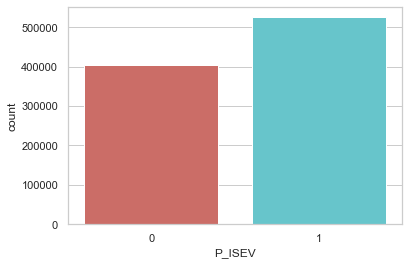

In [23]:
data['P_ISEV'].value_counts()
sns.countplot(x='P_ISEV', data=data, palette='hls')
plt.show()

# Logistic Regression

# SVM

In [ ]:
cleaned_data = pd.read_csv("cleaned_data.csv") 

X = cleaned_data.drop('P_ISEV', axis=1)
y = cleaned_data['P_ISEV']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# Neural Network